# Asynchronous Programming and _Concurrency_ in Python

<center>An overview of parallelization techniques</center>

<center>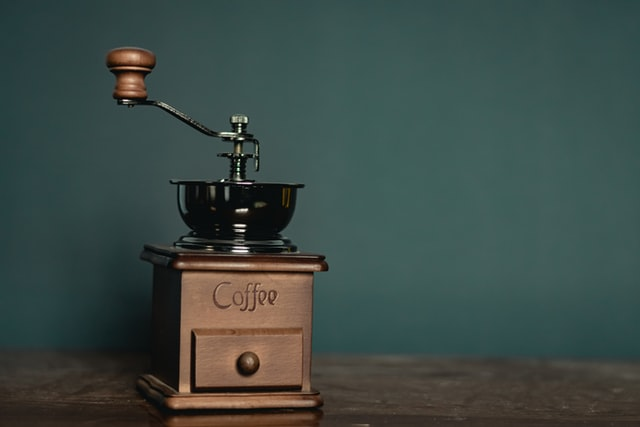</center>

<div style="text-align: right; margin-top: 2rem;">by Andreas Hasenkopf</div>

## Content

1. Generators
1. Multi-Threading & Multi-Processing
1. Coroutines
1. Distributed Processing

**Note**: This presentation was created with Python **3.8**.

## Generators

Somewhat short of being truely asynchronous, generators empower us to produce values _just in time_:


In [6]:
"""
List comprehenseion vs. Generator comprehension

There is no such thing as a tuple-comprehension
"""
results1 = (x**2 for x in range(1, 21))
results2 = [x**2 for x in range(1, 21)]
print("Results:", results1, "\n", *results1)
print("Results:", results2, "\n", *results2)

Results: <generator object <genexpr> at 0x7fe7183c8740> 
 1 4 9 16 25 36 49 64 81 100 121 144 169 196 225 256 289 324 361 400
Results: [1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400] 
 1 4 9 16 25 36 49 64 81 100 121 144 169 196 225 256 289 324 361 400


In [4]:
"""Generator function"""
def fun():
    for x in range(1, 21):
        yield x**2

results = fun()
print("Results:", results, "\n", *results)

Results: <generator object fun at 0x7fe7183c8200> 
 1 4 9 16 25 36 49 64 81 100 121 144 169 196 225 256 289 324 361 400


## Multi-Threading & Multi-Processing

* Both **threads** and **processes** allow implementation of _concurrency_.
* They only differ in the way this is achieved.

### Processes

* True parallen execuition.
* Best suited for CPU-bound tasks.

### Threads

* Actual OS threads, but limited to one CPU core.
* Best suited for IO-bound tasks (i.e. CPU is waiting for something, e.g. disk IO, HTTP requests, ...).
* Known as _Pre-emptive multitasking_.

### Modules in the Standard Library

* Low-level: [`os`](https://docs.python.org/3.9/library/os.html)
* High-level: [`multiprocessing`](https://docs.python.org/3.9/library/multiprocessing.html) & [`multithreading`](https://docs.python.org/3.9/library/multithreading.html)
* Abstract: [`concurrent.futures`](https://docs.python.org/3.9/library/concurrent.futures.html)

### Multi-Processing

* Offered API is _identical_ to `multithreading`
* `Pool`s for parallelizing functions
* `Process`es for writing dedicated processes
* Tools for inter-process communication (`Queue`, `Lock`, Shared Memory, ...)

Let's look at some examples to parallelize the same tasks using `multiprocessing` in different ways...

In [17]:
"""Simple parallelizaiton using a Pool"""
import multiprocessing

def fun(x):
    return x**2

with multiprocessing.Pool() as pool:
    results = pool.map(fun, range(1, 21), chunksize=1)
    print(results)

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400]


In [7]:
"""Less simple parallelizaiton of the same task using a Process"""
import queue              # Note: This example only illustrates
import multiprocessing    #       how much boiler plate code can
                          #       be saved by using a `Pool`.
def fun(x):
    return x**2

class Fun(multiprocessing.Process):
    queue_tasks = multiprocessing.JoinableQueue()
    queue_results = multiprocessing.JoinableQueue()

    def run(self):
        while True:
            try:
                x = self.queue_tasks.get(timeout=.1)
            except queue.Empty:
                continue
            self.queue_results.put(fun(x))
            self.queue_tasks.task_done()

for x in range(1, 21):
    Fun.queue_tasks.put(x)

procs = [Fun() for x in range(5)]
for p in procs:
    p.start()

results = []
Fun.queue_tasks.join()
while True:
    try:
        results.append(Fun.queue_results.get(timeout=.1))
    except queue.Empty:
        break

for p in procs:
    p.terminate()

print("Results", results)


Results [1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400]


<center>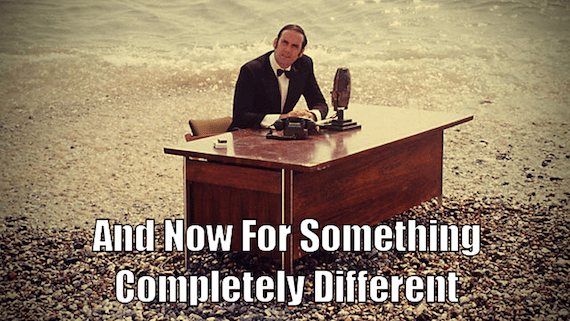</center>

### ... Abstraction

Let's look at the same example, but with the abstraction layer from `concurrent.futures`:

In [5]:
"""Submit elements one-by-one to abstract pool"""
import os
import random as rnd
import concurrent.futures as cf

def fun(x):
    return x, x**2, os.getpid()

with cf.ProcessPoolExecutor() as pool:
    futures = []
    for _ in range(10):
        future = pool.submit(fun, rnd.randint(1, 20))
        futures.append(future)

    for future in cf.as_completed(futures):
        print("Result: f({:2d}) = {:3d} (from PID: {:6d})".format(*future.result()))

Result: f( 8) =  64 (from PID:  56131)
Result: f( 9) =  81 (from PID:  56132)
Result: f( 8) =  64 (from PID:  56132)
Result: f( 2) =   4 (from PID:  56133)
Result: f( 7) =  49 (from PID:  56134)
Result: f(16) = 256 (from PID:  56135)
Result: f(12) = 144 (from PID:  56137)
Result: f(20) = 400 (from PID:  56134)
Result: f(12) = 144 (from PID:  56139)
Result: f( 9) =  81 (from PID:  56140)


## Coroutines

* Inspired by generators.
* Known as _Cooperative multitasking_.

### How does this differ from Threading?

* With `multithreading` the OS is in charge of switching between threads during execution of tasks.
* For coroutines the developer needs to declare _breakpoints_ (aka _awaitables_):
  * The interpreter "waits" for results at these breakpoints.
  * But instead of waiting it works on another task.

In [25]:
"""Simple coroutine example"""
from asyncio import gather, get_event_loop

async def fun(x):
    return x**2

async def main():
    results = await gather(*(fun(x) for x in range(1, 21)))
    print("Results:", results)
    
# Normally we would use: 
# Note: `run` was added in Python 3.7
# `asynciorun(main())`

# ... but Jupyter starts an event loop of it's own
loop = get_event_loop()
task = loop.create_task(main())
await task

Results: [1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400]


In [37]:
"""An actual IO-bound problem"""
import asyncio, time

async def ping(hostname):
    cmd = f"ping -c 3 {hostname}"
    start = time.time()
    proc = await asyncio.create_subprocess_shell(
        cmd,
        stdout=asyncio.subprocess.PIPE,
        stderr=asyncio.subprocess.PIPE
    )
    await proc.communicate()
    print(f"{hostname:14}: ping exited with {proc.returncode} in {time.time() - start:.2f} seconds")


async def main(hostnames):
    start = time.time()
    await asyncio.gather(*(ping(host) for host in hostnames))
    print(f"Total duration: {time.time() - start:.2f} seconds")


hosts = ["microsoft.com", "suse.com", "google.com", "yahoo.com", "redhat.com"]
loop = asyncio.get_event_loop()
task = loop.create_task(main(hosts))
await task

google.com    : ping exited with 0 in 2.03 seconds
suse.com      : ping exited with 0 in 2.06 seconds
yahoo.com     : ping exited with 0 in 2.19 seconds
redhat.com    : ping exited with 0 in 2.19 seconds
microsoft.com : ping exited with 1 in 12.04 seconds
Total duration: 12.04


## Distributed Processing

Let's extend Multi-Processing to multiple hosts and build a cluster with _Celery_ and RabbitMQ.

### Packages

* [`celery`](https://docs.celeryproject.org/en/stable/)


In [4]:
import os, multiprocessing, celery

app = celery.Celery('demo', broker='amqp://guest@localhost', backend="rpc://")

@app.task
def fun(x):
    return x, x**2, os.getpid()

# Note: Usually we start the workers a different way, e.g. as systemd services
worker = multiprocessing.Process(
    target=lambda: app.start(argv=["worker", "-c", "4"]))
worker.start()
results = [fun.delay(x) for x in range(1, 5)]
print("Results:")
while results:
    result = results.pop()
    if result.ready():
        print(result.result)
    else:
        results.append(result)

worker.kill()

Results:
[4, 16, 55942]
[3, 9, 55944]
[2, 4, 55941]
[1, 1, 55943]


## Thank you

Do you have any questions?


## References

1. [Real Python: Async IO in Python](https://realpython.com/async-io-python/)
2. [Real Python: Speed Up Your Python Program With Concurrency](https://realpython.com/python-concurrency/)
3. [Celery Docs](https://docs.celeryproject.org/en/stable/)